# Code for simulations

Import statements

In [ ]:
addprocs(4);  # change this to number of cores

@everywhere using HDF5, JLD
@everywhere using Distributions
@everywhere using QR
@everywhere using Gurobi
@everywhere using CDLasso

Code for oracle simulations. This is copied from the file `one_coefficient_oracle.jl `

In [ ]:
@everywhere function generate_data(
    rep;
    corType = 1,
    noiseType = 1
    )

  # random seed
  srand(rep)

  # generate data
  p = 1500
  n = 1000
  s = 10

  if corType == 1
    # equal correlation
    rho = 0.5
    Sigma = full(blkdiag(sparse(rho * ones(s+5,s+5) + (1-rho) * eye(s+5)), speye(p-s-5)))
  elseif corType == 2
    # toeplitz
    rho = 0.8
    Sigma = zeros(Float64, p,p)
    for a=1:p
      for b=a:p
        t = rho^abs(a-b)
        Sigma[a,b] = t
        Sigma[b,a] = t
      end
    end
  elseif corType == 3
    # toeplitz
    rho = 0.1
    Sigma = zeros(Float64, p,p)
    for a=1:p
      for b=a:p
        t = rho^abs(a-b)
        Sigma[a,b] = t
        Sigma[b,a] = t
      end
    end
  else
    error("Not implemented")
  end
  sqSigma = sqrtm(Sigma)

  beta = linspace(1., 0.5, s)
  X = randn(n, p) * sqSigma
  tX = hcat(ones(n), X)
  if noiseType == 1
    err_d = Normal()
  elseif noiseType == 2
    err_d = TDist(1)
  elseif noiseType == 3
    err_d = TDist(3)
  else
    error("Not implemented")
  end
  errTerm = rand(err_d, n)
  Y = X[:,1:s] * beta + errTerm

  Y, X, beta, n, p, s
end


@everywhere function estimCoeff(
    rep;
    tau = 0.5,
    j = 1,
    lambdaQR = 0.1,
    lambdaLasso = 0.1,
    corType = 1,
    noiseType = 1,
    h = 0.06
    )

  Y, X, true_beta, n, p, s = generate_data(rep; corType=corType, noiseType=noiseType)
  p = 10
  X = X[:, 1:p]

  solver = GurobiSolver(Method=1, OutputFlag=0)
  qr_problem = QRProblem(solver, X, Y)
  @time QR.solve!(qr_problem, 0., tau)
  intercept, ebeta = getBeta(qr_problem)
  a2 = getXi(qr_problem)

  lambda = fill(0., p)
  solve!(qr_problem, lambda, tau - 2*h)
  a3 = getXi(qr_problem)
  
  solve!(qr_problem, lambda, tau + 2*h)
  a1 = getXi(qr_problem)

  spF = dot(Y, a1 - 2*a2 + a3) / 4 / h^2  

  A = cov(X, corrected=false, mean=0.)

  hb = ebeta[j]
  eSigma = inv(A)[j,j] * tau * (1 - tau) * spF^2 / n
  
  tb = true_beta[j]
  hb, eSigma, spF, (hb - tb) / sqrt(eSigma)
end

In [ ]:
numTests = 500
res = pmap(x -> estimCoeff(
             x;
             tau = 0.5,
             j = 1,
             lambdaQR = 0.1,
             lambdaLasso = 0.1,
             corType = 1,
             noiseType = 1,
             h = 0.06
             ),
           [1:numTests])
save("oracle_noise_1_cor_1_var_1.jld", "res", res)
res = pmap(x -> estimCoeff(
             x;
             tau = 0.5,
             j = 10,
             lambdaQR = 0.1,
             lambdaLasso = 0.1,
             corType = 1,
             noiseType = 1,
             h = 0.06
             ),
           [1:numTests])
save("oracle_noise_1_cor_1_var_10.jld", "res", res)

###  tau = 0.5, cor = 1, noise = 2

res = pmap(x -> estimCoeff(
             x;
             tau = 0.5,
             j = 1,
             lambdaQR = 0.1,
             lambdaLasso = 0.1,
             corType = 1,
             noiseType = 2,
             h = 0.06
             ),
           [1:numTests])
save("oracle_noise_2_cor_1_var_1.jld", "res", res)
res = pmap(x -> estimCoeff(
             x;
             tau = 0.5,
             j = 10,
             lambdaQR = 0.1,
             lambdaLasso = 0.1,
             corType = 1,
             noiseType = 2,
             h = 0.06
             ),
           [1:numTests])
save("oracle_noise_2_cor_1_var_10.jld", "res", res)

###  tau = 0.5, cor = 3, noise = 1

res = pmap(x -> estimCoeff(
             x;
             tau = 0.5,
             j = 1,
             lambdaQR = 0.1,
             lambdaLasso = 0.1,
             corType = 3,
             noiseType = 1,
             h = 0.06
             ),
           [1:numTests])
save("oracle_noise_1_cor_3_var_1.jld", "res", res)
res = pmap(x -> estimCoeff(
             x;
             tau = 0.5,
             j = 10,
             lambdaQR = 0.1,
             lambdaLasso = 0.1,
             corType = 3,
             noiseType = 1,
             h = 0.06
             ),
           [1:numTests])
save("oracle_noise_1_cor_3_var_10.jld", "res", res)

###  tau = 0.5, cor = 3, noise = 2

res = pmap(x -> estimCoeff(
             x;
             tau = 0.5,
             j = 1,
             lambdaQR = 0.1,
             lambdaLasso = 0.1,
             corType = 3,
             noiseType = 2,
             h = 0.06
             ),
           [1:numTests])
save("oracle_noise_2_cor_3_var_1.jld", "res", res)
res = pmap(x -> estimCoeff(
             x;
             tau = 0.5,
             j = 10,
             lambdaQR = 0.1,
             lambdaLasso = 0.1,
             corType = 3,
             noiseType = 2,
             h = 0.06
             ),
           [1:numTests])
save("oracle_noise_2_cor_3_var_10.jld", "res", res)

# Plot results

In [5]:
using PyPlot
using HDF5, JLD
using Distributions

Gaussian noise, equicorrelation design, oracle procedure

In [6]:
numTests = 500
res = load("sims/oracle_noise_1_cor_1_var_1.jld", "res")
ores = zeros(numTests)
for i=1:numTests
  ores[i] = res[i][4]
end
plt.hist(ores, min(20,numTests), normed=true)
ax = gca()
ax[:set_xlim]([-4.5, 4.5])
d = Normal()
xarr = -4.5:0.01:4.5
plot(xarr, pdf(d, xarr), color="red", linewidth=3)
title(L"$\Sigma_{ab} = 0.5$, $\epsilon\sim N(0,1)$")
xlabel(L"$(\widehat\beta_1^{\rm oracle} - \beta_1)/s_{\hat \beta_1}$")

PyObject <matplotlib.text.Text object at 0x7f01f80b1210>

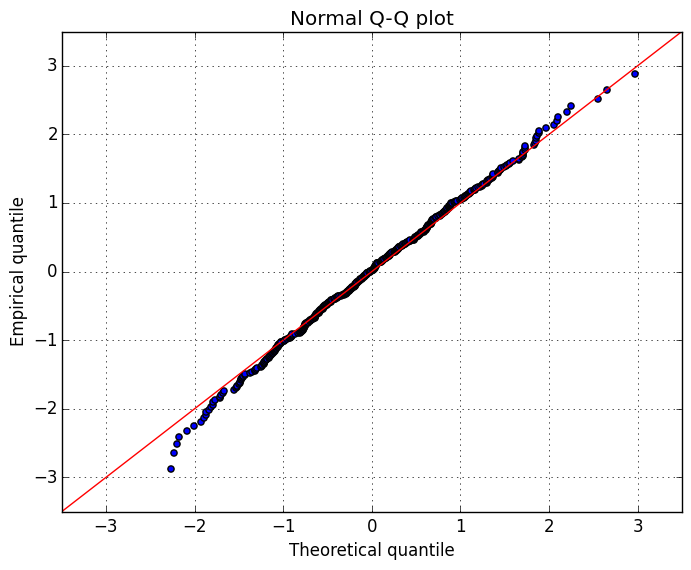

In [23]:
qq = qqbuild(ores, Normal())
scatter(qq.qx, qq.qy)
ax = gca()
ax[:set_ylim]([-3.5, 3.5])
ax[:set_xlim]([-3.5, 3.5])
xx=-3.5:0.01:3.5
plot(xx,xx, color="red")
title("Normal Q-Q plot")
ylabel("Empirical quantile")
xlabel("Theoretical quantile")
grid("on")

In [3]:
res = load("sims/oracle_noise_1_cor_1_var_10.jld", "res")
ores = zeros(numTests)
for i=1:numTests
  ores[i] = res[i][4]
end
plt.hist(ores, min(20,numTests), normed=true)
ax = gca()
ax[:set_xlim]([-4.5, 4.5])
d = Normal()
xarr = -4.5:0.01:4.5
plot(xarr, pdf(d, xarr), color="red", linewidth=3)
title(L"$\Sigma_{ab} = 0.5$, $\epsilon\sim N(0,1)$")
xlabel(L"$(\widehat\beta_{10}^{\rm oracle} - \beta_{10})/s_{\hat \beta_{10}}$")

LoadError: numTests not defined
while loading In[3], in expression starting on line 2

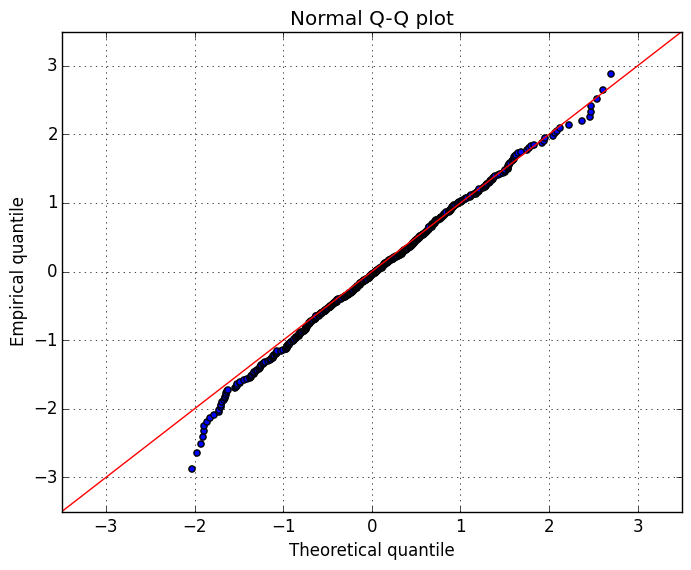

In [26]:
qq = qqbuild(ores, Normal())
scatter(qq.qx, qq.qy)
ax = gca()
ax[:set_ylim]([-3.5, 3.5])
ax[:set_xlim]([-3.5, 3.5])
xx=-3.5:0.01:3.5
plot(xx,xx, color="red")
title("Normal Q-Q plot")
ylabel("Empirical quantile")
xlabel("Theoretical quantile")
grid("on")

TDist(1) noise, equicorrelation design, oracle procedure

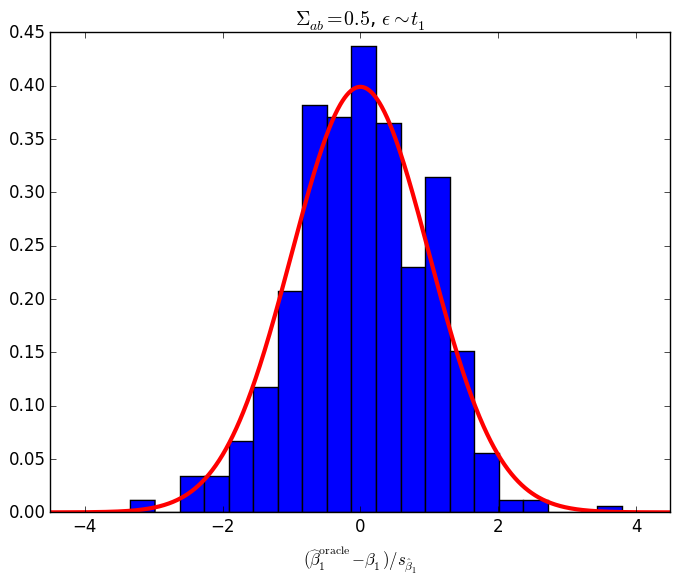

PyObject <matplotlib.text.Text object at 0x7fbe945c7c10>

In [27]:
res = load("sims/oracle_noise_2_cor_1_var_1.jld", "res")
ores = zeros(numTests)
for i=1:numTests
  ores[i] = res[i][4]
end
plt.hist(ores, min(20,numTests), normed=true)
ax = gca()
ax[:set_xlim]([-4.5, 4.5])
d = Normal()
xarr = -4.5:0.01:4.5
plot(xarr, pdf(d, xarr), color="red", linewidth=3)
title(L"$\Sigma_{ab} = 0.5$, $\epsilon\sim t_1$")
xlabel(L"$(\widehat\beta_1^{\rm oracle} - \beta_1)/s_{\hat \beta_1}$")

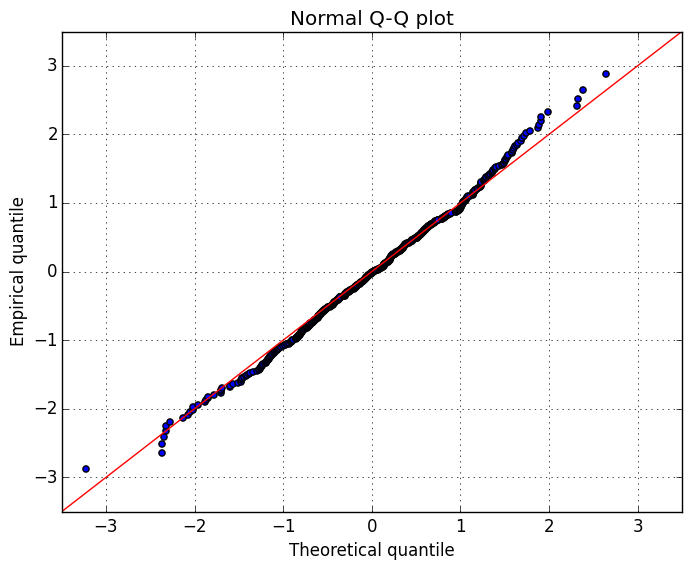

In [28]:
qq = qqbuild(ores, Normal())
scatter(qq.qx, qq.qy)
ax = gca()
ax[:set_ylim]([-3.5, 3.5])
ax[:set_xlim]([-3.5, 3.5])
xx=-3.5:0.01:3.5
plot(xx,xx, color="red")
title("Normal Q-Q plot")
ylabel("Empirical quantile")
xlabel("Theoretical quantile")
grid("on")

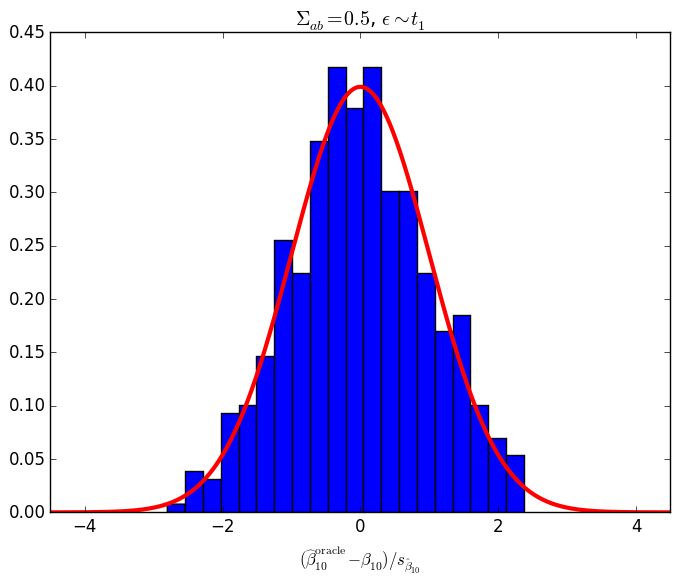

PyObject <matplotlib.text.Text object at 0x7fbe9409add0>

In [32]:
res = load("sims/oracle_noise_2_cor_1_var_10.jld", "res")
ores = zeros(numTests)
for i=1:numTests
  ores[i] = res[i][4]
end
plt.hist(ores, min(20,numTests), normed=true)
ax = gca()
ax[:set_xlim]([-4.5, 4.5])
d = Normal()
xarr = -4.5:0.01:4.5
plot(xarr, pdf(d, xarr), color="red", linewidth=3)
title(L"$\Sigma_{ab} = 0.5$, $\epsilon\sim t_1$")
xlabel(L"$(\widehat\beta_{10}^{\rm oracle} - \beta_{10})/s_{\hat \beta_{10}}$")

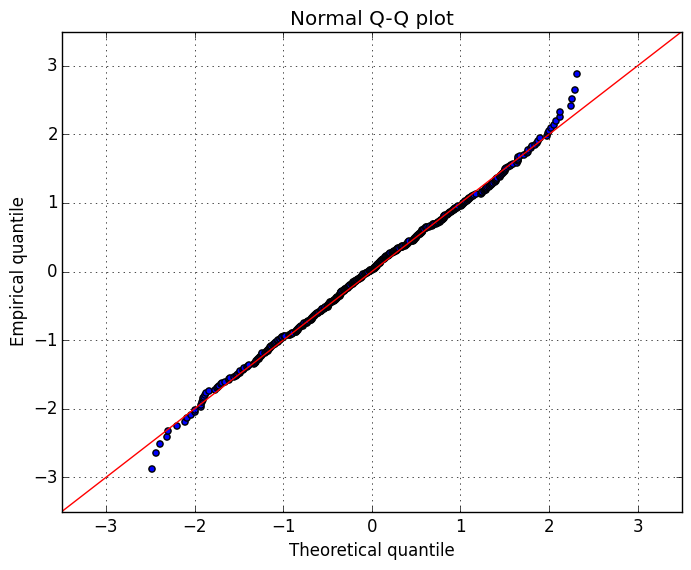

In [30]:
qq = qqbuild(ores, Normal())
scatter(qq.qx, qq.qy)
ax = gca()
ax[:set_ylim]([-3.5, 3.5])
ax[:set_xlim]([-3.5, 3.5])
xx=-3.5:0.01:3.5
plot(xx,xx, color="red")
title("Normal Q-Q plot")
ylabel("Empirical quantile")
xlabel("Theoretical quantile")
grid("on")

Gaussian noise, toeplitz design, oracle procedure

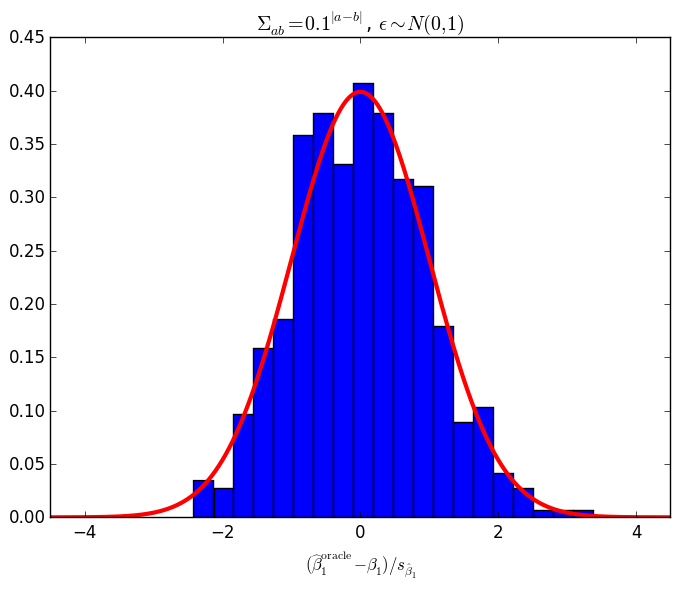

PyObject <matplotlib.text.Text object at 0x7fbe93e5ad10>

In [34]:
res = load("sims/oracle_noise_1_cor_3_var_1.jld", "res")
ores = zeros(numTests)
for i=1:numTests
  ores[i] = res[i][4]
end
plt.hist(ores, min(20,numTests), normed=true)
ax = gca()
ax[:set_xlim]([-4.5, 4.5])
d = Normal()
xarr = -4.5:0.01:4.5
plot(xarr, pdf(d, xarr), color="red", linewidth=3)
title(L"$\Sigma_{ab} = 0.1^{|a-b|}$, $\epsilon\sim N(0,1)$")
xlabel(L"$(\widehat\beta_{1}^{\rm oracle} - \beta_{1})/s_{\hat \beta_1}$")

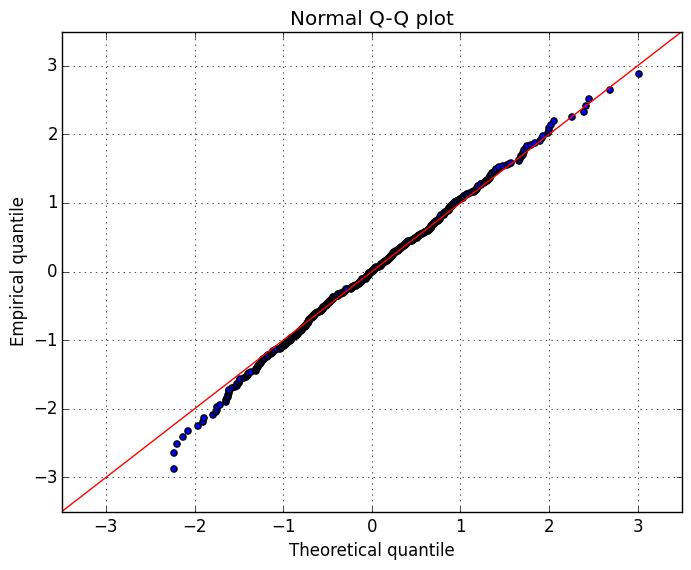

In [35]:
qq = qqbuild(ores, Normal())
scatter(qq.qx, qq.qy)
ax = gca()
ax[:set_ylim]([-3.5, 3.5])
ax[:set_xlim]([-3.5, 3.5])
xx=-3.5:0.01:3.5
plot(xx,xx, color="red")
title("Normal Q-Q plot")
ylabel("Empirical quantile")
xlabel("Theoretical quantile")
grid("on")

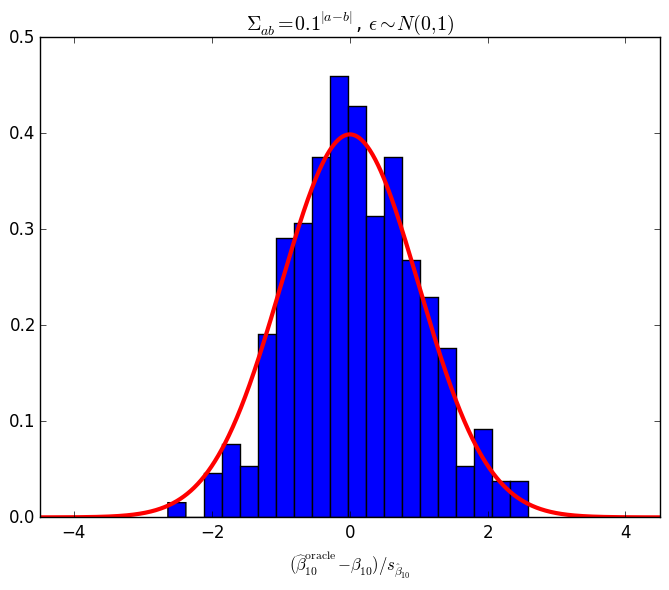

PyObject <matplotlib.text.Text object at 0x7fbe93a6f110>

In [38]:
res = load("sims/oracle_noise_1_cor_3_var_10.jld", "res")
ores = zeros(numTests)
for i=1:numTests
  ores[i] = res[i][4]
end
plt.hist(ores, min(20,numTests), normed=true)
ax = gca()
ax[:set_xlim]([-4.5, 4.5])
d = Normal()
xarr = -4.5:0.01:4.5
plot(xarr, pdf(d, xarr), color="red", linewidth=3)
title(L"$\Sigma_{ab} = 0.1^{|a-b|}$, $\epsilon\sim N(0,1)$")
xlabel(L"$(\widehat\beta_{10}^{\rm oracle} - \beta_{10})/s_{\hat \beta_{10}}$")

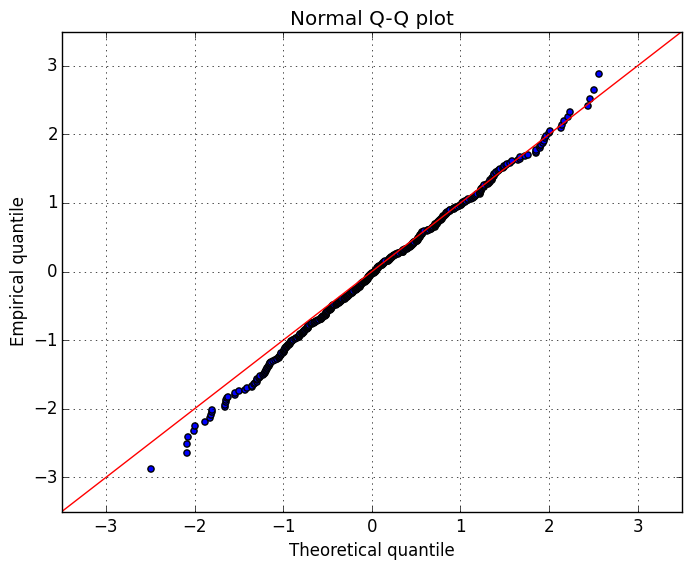

In [37]:
qq = qqbuild(ores, Normal())
scatter(qq.qx, qq.qy)
ax = gca()
ax[:set_ylim]([-3.5, 3.5])
ax[:set_xlim]([-3.5, 3.5])
xx=-3.5:0.01:3.5
plot(xx,xx, color="red")
title("Normal Q-Q plot")
ylabel("Empirical quantile")
xlabel("Theoretical quantile")
grid("on")

TDist(1), toeplitz design, oracle procedure

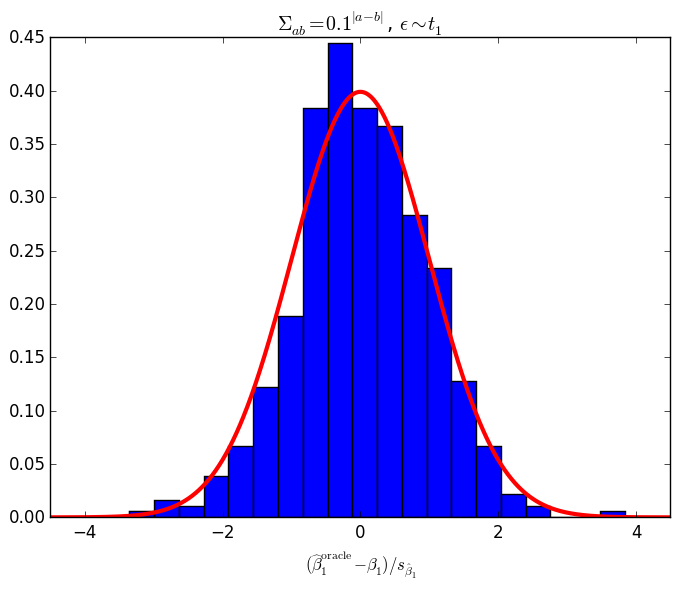

PyObject <matplotlib.text.Text object at 0x7fbe936c6310>

In [41]:
res = load("sims/oracle_noise_2_cor_3_var_1.jld", "res")
ores = zeros(numTests)
for i=1:numTests
  ores[i] = res[i][4]
end
plt.hist(ores, min(20,numTests), normed=true)
ax = gca()
ax[:set_xlim]([-4.5, 4.5])
d = Normal()
xarr = -4.5:0.01:4.5
plot(xarr, pdf(d, xarr), color="red", linewidth=3)
title(L"$\Sigma_{ab} = 0.1^{|a-b|}$, $\epsilon\sim t_1$")
xlabel(L"$(\widehat\beta_{1}^{\rm oracle} - \beta_{1})/s_{\hat \beta_1}$")

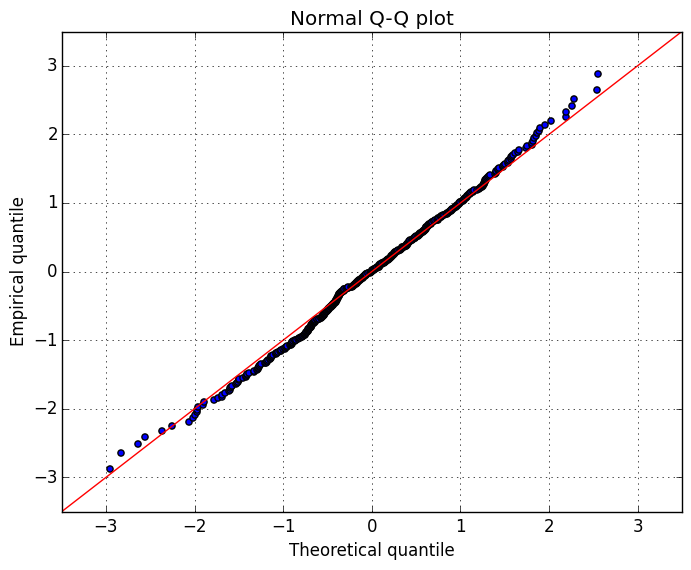

In [42]:
qq = qqbuild(ores, Normal())
scatter(qq.qx, qq.qy)
ax = gca()
ax[:set_ylim]([-3.5, 3.5])
ax[:set_xlim]([-3.5, 3.5])
xx=-3.5:0.01:3.5
plot(xx,xx, color="red")
title("Normal Q-Q plot")
ylabel("Empirical quantile")
xlabel("Theoretical quantile")
grid("on")

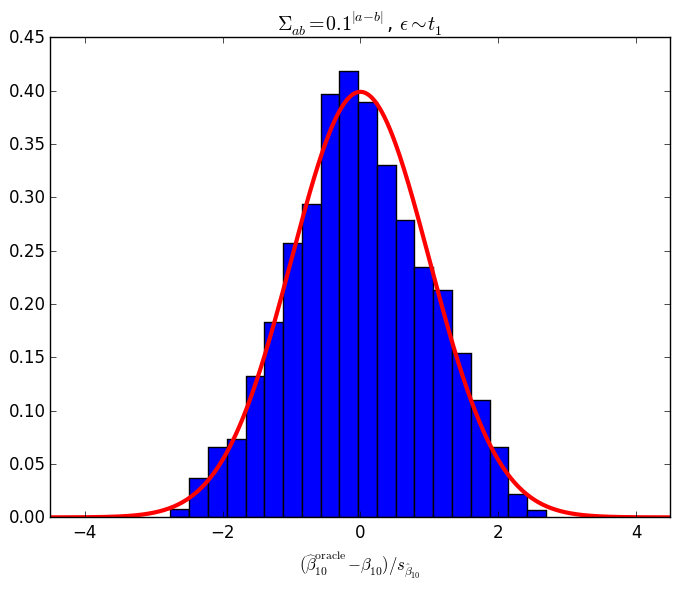

PyObject <matplotlib.text.Text object at 0x7fbe934e4290>

In [43]:
res = load("sims/oracle_noise_2_cor_3_var_10.jld", "res")
ores = zeros(numTests)
for i=1:numTests
  ores[i] = res[i][4]
end
plt.hist(ores, min(20,numTests), normed=true)
ax = gca()
ax[:set_xlim]([-4.5, 4.5])
d = Normal()
xarr = -4.5:0.01:4.5
plot(xarr, pdf(d, xarr), color="red", linewidth=3)
title(L"$\Sigma_{ab} = 0.1^{|a-b|}$, $\epsilon\sim t_1$")
xlabel(L"$(\widehat\beta_{10}^{\rm oracle} - \beta_{10})/s_{\hat \beta_{10}}$")

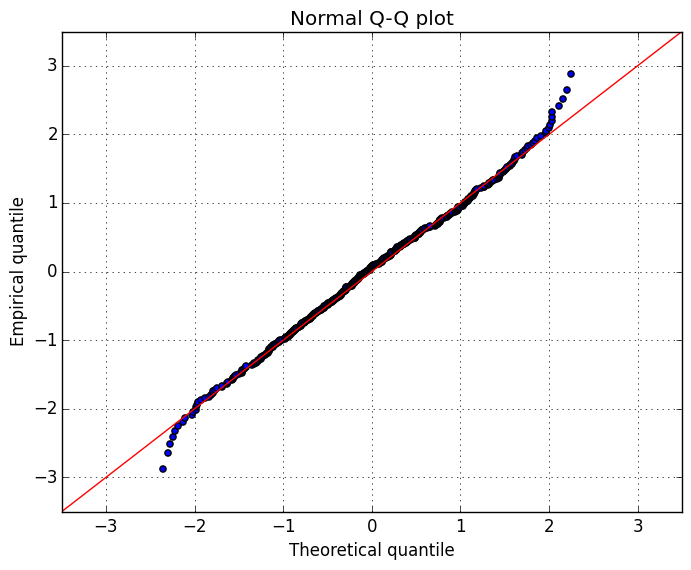

In [44]:
qq = qqbuild(ores, Normal())
scatter(qq.qx, qq.qy)
ax = gca()
ax[:set_ylim]([-3.5, 3.5])
ax[:set_xlim]([-3.5, 3.5])
xx=-3.5:0.01:3.5
plot(xx,xx, color="red")
title("Normal Q-Q plot")
ylabel("Empirical quantile")
xlabel("Theoretical quantile")
grid("on")

# Our estimator

In [7]:
numTests = 500
res = load("sims/noise_1_cor_1_var_1.jld", "res")
ores = zeros(numTests)
for i=1:numTests
  ores[i] = res[i][4]
end
plt.hist(ores, min(20,numTests), normed=true)
ax = gca()
ax[:set_xlim]([-4.5, 4.5])
d = Normal()
xarr = -4.5:0.01:4.5
plot(xarr, pdf(d, xarr), color="red", linewidth=3)
title(L"$\Sigma_{ab} = 0.5$, $\epsilon\sim N(0,1)$")
xlabel(L"$(\widehat\beta_1 - \beta_1)/s_{\hat \beta_1}$")

PyObject <matplotlib.text.Text object at 0x7f01e3505590>

In [10]:
numTests = 500
res = load("sims/noise_1_cor_1_var_10.jld", "res")
ores = zeros(numTests)
for i=1:numTests
  ores[i] = res[i][4]
end
plt.hist(ores, min(20,numTests), normed=true)
ax = gca()
ax[:set_xlim]([-4.5, 4.5])
d = Normal()
xarr = -4.5:0.01:4.5
plot(xarr, pdf(d, xarr), color="red", linewidth=3)
title(L"$\Sigma_{ab} = 0.5$, $\epsilon\sim N(0,1)$")
xlabel(L"$(\widehat\beta_{10} - \beta_{10})/s_{\hat \beta_{10}}$")

PyObject <matplotlib.text.Text object at 0x7f01e3275f50>

In [12]:
numTests = 500
res = load("sims/noise_1_cor_1_var_20.jld", "res")
ores = zeros(numTests)
for i=1:numTests
  ores[i] = res[i][4]
end
plt.hist(ores, min(20,numTests), normed=true)
ax = gca()
ax[:set_xlim]([-4.5, 4.5])
d = Normal()
xarr = -4.5:0.01:4.5
plot(xarr, pdf(d, xarr), color="red", linewidth=3)
title(L"$\Sigma_{ab} = 0.5$, $\epsilon\sim N(0,1)$")
xlabel(L"$(\widehat\beta_{20} - \beta_{20})/s_{\hat \beta_{20}}$")

PyObject <matplotlib.text.Text object at 0x7f01e2d5cf50>

0.29243352906349773

In [13]:
numTests = 500
res = load("sims/noise_2_cor_1_var_1.jld", "res")
ores = zeros(numTests)
for i=1:numTests
  ores[i] = res[i][4]
end
plt.hist(ores, min(20,numTests), normed=true)
ax = gca()
ax[:set_xlim]([-4.5, 4.5])
d = Normal()
xarr = -4.5:0.01:4.5
plot(xarr, pdf(d, xarr), color="red", linewidth=3)
title(L"$\Sigma_{ab} = 0.5$, $\epsilon\sim t_1$")
xlabel(L"$(\widehat\beta_1 - \beta_1)/s_{\hat \beta_1}$")

PyObject <matplotlib.text.Text object at 0x7f01f8080ad0>

In [14]:
numTests = 500
res = load("sims/noise_2_cor_1_var_10.jld", "res")
ores = zeros(numTests)
for i=1:numTests
  ores[i] = res[i][4]
end
plt.hist(ores, min(20,numTests), normed=true)
ax = gca()
ax[:set_xlim]([-4.5, 4.5])
d = Normal()
xarr = -4.5:0.01:4.5
plot(xarr, pdf(d, xarr), color="red", linewidth=3)
title(L"$\Sigma_{ab} = 0.5$, $\epsilon\sim t_1$")
xlabel(L"$(\widehat\beta_{10} - \beta_{10})/s_{\hat \beta_{10}}$")

PyObject <matplotlib.text.Text object at 0x7f01e2af3710>

In [15]:
numTests = 500
res = load("sims/noise_2_cor_1_var_20.jld", "res")
ores = zeros(numTests)
for i=1:numTests
  ores[i] = res[i][4]
end
plt.hist(ores, min(20,numTests), normed=true)
ax = gca()
ax[:set_xlim]([-4.5, 4.5])
d = Normal()
xarr = -4.5:0.01:4.5
plot(xarr, pdf(d, xarr), color="red", linewidth=3)
title(L"$\Sigma_{ab} = 0.5$, $\epsilon\sim t_1$")
xlabel(L"$(\widehat\beta_{20} - \beta_{20})/s_{\hat \beta_{20}}$")

PyObject <matplotlib.text.Text object at 0x7f01e2ce3e50>